In [13]:
from pytket.circuit import Circuit, Unitary1qBox, Unitary2qBox
import numpy as np
from pytket.circuit import OpType

# u1 = np.asarray([[1, 0],
#                  [0, 1]])
# u1box = Unitary1qBox(u1)

input_angle = 0.73  # angle as number of half turns
unitary_circuit = Circuit(1).U1(input_angle, 0)  # Base unitary for controlled U ops

In [14]:
from pytket.circuit import Op


base_u1 = Op.create(OpType.U1, [0.5])

In [15]:
from pytket.circuit import QControlBox
from pytket.circuit import CircBox

controlled_u1 = QControlBox(CircBox(unitary_circuit), n=2)

In [16]:
from pytket.pauli import PauliStabiliser
from pytket.pauli import Pauli

phase_stabilise_z = PauliStabiliser([Pauli.Z], 1)


In [35]:
from pytket import Circuit
from pytket import OpType
from pytket.circuit.display import render_circuit_jupyter

my_circuit = Circuit(4)
cr = my_circuit.add_c_register("c", 4)

# block 1
my_circuit.H(0).X(1).X(2).X(3)

# block 2
my_circuit.add_gate(controlled_u1, [0, 1, 3])
my_circuit.add_gate(controlled_u1, [0, 1, 3])
my_circuit.add_gate(controlled_u1, [0, 1, 3])
my_circuit.add_gate(controlled_u1, [0, 1, 3])

#block 3
my_circuit.H(0)
my_circuit.Measure(0, 0)
my_circuit.Reset(0)
my_circuit.H(0)
my_circuit.Rz(-0.5, 0, condition_bits= [0], condition_value=1)

#block 4
my_circuit.add_gate(controlled_u1, [0, 1, 3])
my_circuit.add_gate(controlled_u1, [0, 1, 3])

#block 5
my_circuit.H(0)
my_circuit.Measure(0, 1)
my_circuit.Reset(0)
my_circuit.H(0)

#block 6
my_circuit.Rz(-0.25, 0, condition_bits=[0], condition_value=1)
my_circuit.Rz(-0.5, 0, condition_bits=[1], condition_value=1)
my_circuit.Rz(-0.75, 0, condition_bits=[2], condition_value=1)
my_circuit.add_gate(controlled_u1, [0, 1, 3])
my_circuit.add_gate(controlled_u1, [0, 1, 3])

#block 7
my_circuit.H(0)
my_circuit.Measure(0, 2)
my_circuit.Reset(0)
my_circuit.H(0)

#block 7
my_circuit.Rz(-0.2, 0, condition_bits=[0], condition_value=1)
my_circuit.Rz(-0.4, 0, condition_bits=[1], condition_value=1)
my_circuit.Rz(-0.6, 0, condition_bits=[2], condition_value=1)
my_circuit.Rz(-0.8, 0, condition_bits=[3], condition_value=1)
my_circuit.add_gate(controlled_u1, [0, 1, 3])

# end
my_circuit.H(0)
my_circuit.Measure(0, 3)

# my_circuit.measure_all()

my_circuit.name = "test"

render_circuit_jupyter(my_circuit)

In [36]:
from pytket.extensions.nexus import NexusBackend, QuantinuumConfig, Nexus
from datetime import datetime

nexus = Nexus()
my_project = nexus.new_project(name=f"Nexus iQuHack tutorial project! - {datetime.now()}")

device = "H1-1E"
# device = "H1-1LE"

configuration = QuantinuumConfig(device_name=device)
# , user_group="iQuHACK_2024"

backend = NexusBackend(
    backend_config= configuration, 
    project= my_project
)


New project created: Nexus iQuHack tutorial project! - 2024-02-03 23:49:54.572721

Started using project with name: Nexus iQuHack tutorial project! - 2024-02-03 23:49:54.572721


In [37]:
from pytket.passes import DecomposeBoxes

DecomposeBoxes().apply(my_circuit)

True

In [38]:
from pytket.extensions.nexus import NexusBackend

# Then we'll create a NexusBackend using our config and the project we created
backend = NexusBackend(configuration, project=my_project)


Started using project with name: Nexus iQuHack tutorial project! - 2024-02-03 23:49:54.572721


In [39]:
# Compile the circuit in Nexus
compiled_circ = backend.get_compiled_circuit(my_circuit)

In [40]:
# Run the compiled circuit for 10 shots
handle = backend.process_circuit(compiled_circ, n_shots=10)


# This will give you a ResultHandle
# As with other pytket-backends, a ResultHandle identifies a particular run of the circuit, which you can then use to keep track of the job status.
print(handle)

('ce3dd11e-fe84-437a-b039-bbb02837944d', 1894636)


In [41]:
# Get an update on the status
backend.circuit_status(handle)

CircuitStatus(status=<StatusEnum.SUBMITTED: 'Circuit has been submitted.'>, message='Circuit has been submitted to Nexus for Processing.', error_detail=None, completed_time=None, queued_time=None, submitted_time=datetime.datetime(2024, 2, 3, 23, 50, 4, 288632, tzinfo=datetime.timezone.utc), running_time=None, cancelled_time=None, error_time=None, queue_position=None)

In [42]:
# If the job is COMPLETED we can then retrieve the result with the handle
result = backend.get_result(handle)


result.get_distribution()

{(1, 1, 0, 0): 0.1, (1, 1, 1, 0): 0.5, (1, 1, 1, 1): 0.4}

In [43]:
n_shots = 1000
result = backend.run_circuit(compiled_circ, n_shots)

In [44]:
print(result.get_counts())

Counter({(1, 1, 1, 0): 440, (1, 1, 1, 1): 336, (1, 1, 0, 0): 159, (1, 1, 0, 1): 17, (0, 1, 1, 0): 10, (1, 0, 0, 0): 8, (1, 0, 1, 0): 8, (0, 0, 0, 0): 6, (0, 0, 1, 0): 6, (0, 0, 0, 1): 5, (0, 1, 1, 1): 3, (1, 0, 0, 1): 1, (1, 0, 1, 1): 1})


In [45]:
from pytket.backends.backendresult import BackendResult
import matplotlib.pyplot as plt

In [46]:
def plot_qpe_results(
    sim_result: BackendResult,
    n_strings: int = 10,
    dark_mode: bool = False,
    y_limit: int = 1000,
) -> None:
    """
    Plots results in a barchart given a BackendResult. the number of stings displayed
    can be specified with the n_strings argument.
    """
    counts_dict = sim_result.get_counts()
    sorted_shots = counts_dict.most_common()
    n_most_common_strings = sorted_shots[:n_strings]
    x_axis_values = [str(entry[0]) for entry in n_most_common_strings]  # basis states
    y_axis_values = [entry[1] for entry in n_most_common_strings]  # counts
    if dark_mode:
        plt.style.use("dark_background")
    fig = plt.figure()
    ax = fig.add_axes((0, 0, 0.75, 0.5))
    color_list = ["orange"] * (len(x_axis_values))
    ax.bar(
        x=x_axis_values,
        height=y_axis_values,
        color=color_list,
    )
    ax.set_title(label="Results")
    plt.ylim([0, y_limit])
    plt.xlabel("Basis State")
    plt.ylabel("Number of Shots")
    plt.show()

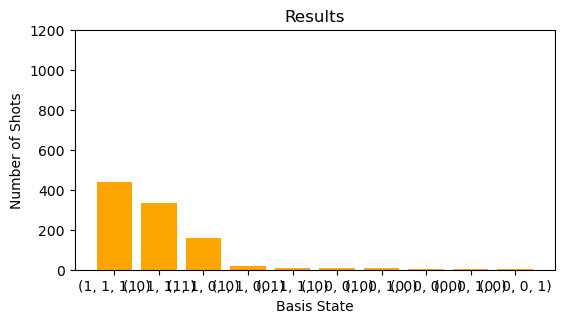

In [47]:
plot_qpe_results(result, y_limit=int(1.2 * n_shots))

In [48]:
from pytket.backends.backendresult import BackendResult

In [49]:
def single_phase_from_backendresult(result: BackendResult) -> float:
    # Extract most common measurement outcome
    basis_state = result.get_counts().most_common()[0][0]
    bitstring = "".join([str(bit) for bit in basis_state])
    integer_j = int(bitstring, 2)

    # Calculate theta estimate
    return integer_j / (2 ** len(bitstring))

In [50]:
theta = single_phase_from_backendresult(result)
print(theta)

0.875


In [51]:
print(input_angle / 2)

0.365


In [52]:
error = round(abs(input_angle - (theta)), 3)
print(error)

0.145
